# WARNING: THIS DOCUMENT IS OUTDATED
Newer documentation is available at: https://github.com/swharden/pyABF/

-----

## Alternative methods to calculate cell capacitance (Cm)
All discussion and code examples up to this point have attempted to calculate capacitance from a voltage step by inspecting the transient. This method uses an abrupt voltage step to cause a capacitive transient in the current trace, and attempts to extract a decay constant from the transient and work from there. Limitations of this method stem from the fact that the transient is extremely fast:

### Disadvantages of the voltage-step method

* Transients are very fast and greatly susceptible to distortion by hardware low-pass filter
* Transients are very fast and greatly susceptible to noise
* Fitting the transient data to a curve is computationally complex, slow, and can fail
* An unluckily-timed IPSC or EPSC will destroy a meaningful curve fit

When considering the alternatives, I found it helpful to consider _why_ the transient is of interest to measurements of Cm. Try this thought experiment:

* If a cell had 0 pF capacitance, it would effortlessly swing to any command voltage.
* If a cell had 0 pF capacitance, it would charge/discharge instantly, and it would produce no transient.
* The transient is the voltage-clamp amplifier trying to "catch-up" to the fact the cell has not _charged_ to the command voltage yet.
* A cell with a greater _capacity_ to _charge_ is a cell with a high _capacitance_.
* What we are really measuring in the transient is how long it takes the cell to "catch-up" to the command voltage.

There are other ways to measure _how long it takes the cell to catch-up to the command voltage_, and they are explored in the following sections.

## Alternative method: voltage clamp ramp
* Since cell capacitance relates to how long it takes the cell to catch-up to the command voltage, one clever way of quantifying this effect is to present it with a moving-target command voltage. 
* Unlike a voltage step which the cell equilibrates with in a  few milliseconds, a sliding voltage-clamp ramp leaves the cell voltage / amplifier current slightly below or above equilibrium. 
* If we apply a voltage ramp in the downward direction and then the same ramp in the upward direction, the cell will lag the moving-target clamp voltage by the same amount in opposite directions.
* Membrane capacitance can be calculated from the difference between the doward-ramp and upward-ramp signals.
* Rather than obsess about the initial transient, we want to ignore it completely! We will therefore discard data at the start and end of changes in ramp direction.

#### Let's start by inspecting our recording
Plot voltage vs. time and current vs. time

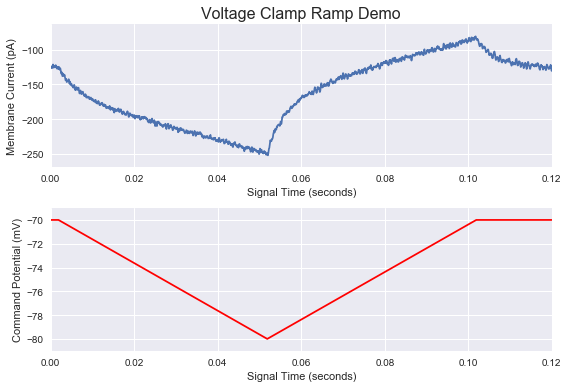

In [20]:
abf=pyabf.ABF("../data/171116sh_0014.abf")
abf.setSweep(8)
ax1=plt.subplot(211)
plt.plot(abf.dataX,abf.dataY)
abf.plotDecorate(title="Voltage Clamp Ramp Demo")
plt.subplot(212,sharex=ax1)
plt.plot(abf.dataX,abf.dataC,color='r')
abf.plotDecorate(command=True,title=None)

#### Now plot clamp current _against_ command voltage (ignore time)

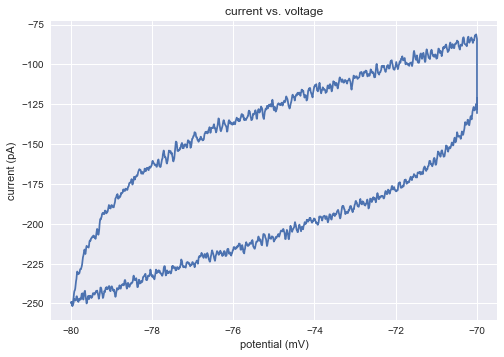

In [21]:
plt.plot(abf.dataC,abf.dataY);
plt.title("current vs. voltage")
plt.ylabel("current (pA)")
plt.xlabel("potential (mV)");

#### What is really happening is that we are rotating in a circle.
Time-encoding the data points by color helps make this clear.

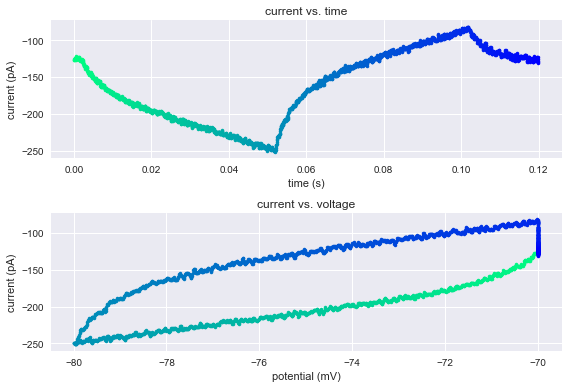

In [22]:
pointCount=len(abf.dataY)

plt.subplot(211)
for i in range(pointCount):
    c=plt.cm.get_cmap("winter_r")(i/pointCount)
    plt.plot(abf.dataX[i],abf.dataY[i],'.',color=c)
plt.title("current vs. time")
plt.ylabel("current (pA)")
plt.xlabel("time (s)")

plt.subplot(212)
for i in range(pointCount):
    c=plt.cm.get_cmap("winter_r")(i/pointCount)
    plt.plot(abf.dataC[i],abf.dataY[i],'.',color=c)
plt.title("current vs. voltage")
plt.ylabel("current (pA)")
plt.xlabel("potential (mV)")
plt.tight_layout()

#### Why is it an oval instead of a line?
The cell's actual voltage can't "keep up" with the command voltage, so the amplifier has to apply ever more current (positive or negative) as the command voltage slides in one way or another. The larger the cell, the larger the capacitance, and the less the amplifier can keep up, so the more the top and bottom line will diverge. 

Let's measure this, avoiding the areas where fast transients may occur (edges).

mark 0: 37
mark 1: 1037
mark 2: 2037


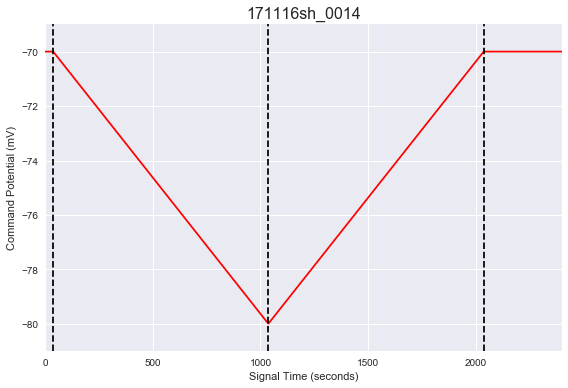

In [23]:
# Note that we know when the protocol V starts by inspecting the epoch start points
plt.plot(abf.dataC,color='r')
abf.plotDecorate(command=True)
for n,i in enumerate(abf.epochStartPoint):
    print("mark %d: %d"%(n,i))
    plt.axvline(i,color='k',ls='--')

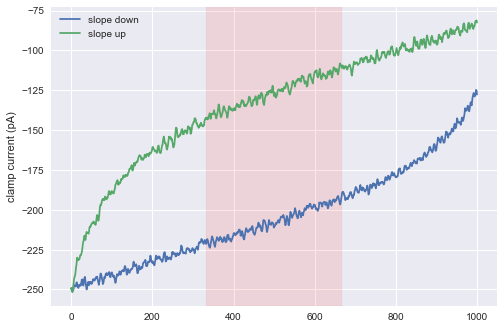

In [24]:
# note that from here we are no longer interested in the time domain
slopeDown=abf.dataY[abf.epochStartPoint[0]:abf.epochStartPoint[1]]
slopeUp=abf.dataY[abf.epochStartPoint[1]:abf.epochStartPoint[2]]
slopeDown=slopeDown[::-1] # reverse the falling slope
plt.plot(slopeDown,label="slope down")
plt.plot(slopeUp,label="slope up")
plt.legend()
plt.ylabel("clamp current (pA)");

I1,I2=int(len(slopeUp)*(1/3)),int(len(slopeUp)*(2/3))
plt.axvspan(I1,I2,alpha=.1,color='r');

From the above graph you will notice the currents are initially monoexponential (that's what you're used to trying to curve-fit!) but they become linear and match the velocity of the voltage-clamp command potential. 

We are trying to get _away_ from the transients and look at the linear regions. Therefore, let's focus only at the center third (shaded area) and discard the third on each side.

command slope: 0.20 V/S
clamp lag (Ic): 40.61 pA


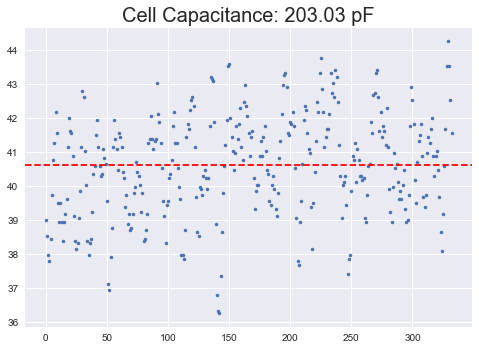

In [48]:
commandSlope = ((abf.epochCommand[1]-abf.epochCommand[0])/1e3)/(abf.epochStartSec[1]-abf.epochStartSec[0])
print("command slope: %.02f V/S"%(commandSlope))

deviation=np.abs(slopeDown[I1:I2]-slopeUp[I1:I2])/2
devAV=np.mean(deviation)
print("clamp lag (Ic): %.02f pA"%(devAV))

plt.plot(deviation,'.')
plt.axhline(devAV,color='r',ls='--');

Cm=devAV/commandSlope
plt.title("Cell Capacitance: %.02f pF"%(Cm),fontsize=20);

**Needs more testing!** Compare values across CJFLab, this, and clampfit.

**Reflections:** This method is more accurate, less disrupted by noise, less prone to distortion by low-pass filtering, and is more computationally simple (and faster) to perform than the traditional step current. Running 50 consecutive 100ms sweeps of this cool protocol is a strong alternative for calculating Cm.

-----

## Alternative method: current clamp step
An important distinction exists between the voltage-clamp time constant (here called _tau_) and the cell membrane time constant (here called _tauMemb_). They can both be used to infer capacitance, but it is important to understand what they are.

**tau** - _the rate-constant of the current transient to a voltage step_
* a function of the _amplifier/cell configuration_.
* reflects how fast the amplifier can charge/discharge the cell.
* will be a large value (slow time constant) for cells with high capacitance.
* membrane ion conductances do not meaningfully influence this measurement.
* it is used (in combination with series / access resistance) to infer information about size of the cell. 
* because it is a measurement of the amplifier's ability to clamp the voltage of a cell, it is extremely fast.

**tauMemb** - _the rate-constant of the voltage transient to a current step)_
* a true function of the cell membrane
* reflects the "desire" of the cell to rectify its voltage
* stabilization is achieved by ion flux through ion channels (leak and active) in the membrane
* this time constant, in itself, is only indirectly related to capacitance. _(If we knew the exact number of open channels and all their ionic forces, perhaps we could use this value to calculate Cm, but we usually don't, and we usually can't, so we typically don't try)_

# Resources
* [Membrane Capacitance Measurements Revisited: Dependence of Capacitance Value on Measurement Method in Nonisopotential Neurons](http://jn.physiology.org/content/102/4/2161)
* [Letter to the editor: Accurate cell capacitance determination from a single
voltage step: a reminder to avoid unnecessary pitfalls](http://ajpheart.physiology.org/content/ajpheart/311/4/H1072.full.pdf)
* [Some random formulas](https://www.moleculardevices.com/what-continuous-single-electrode-voltage-clamp-csevc)
